# **Analisi e Preprocessing del Dataset**

---

Il dataset scaricabile al seguente link: [Download dataset](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/data), è strutturato in maniera organizzata con le seguenti cartelle principali:  
- **Train**
- **Validation**
- **Test** 
- **Auto_test**

All'interno di ciascun set, troviamo 5 sottocartelle, denominate con i numeri **0**, **1**, **2**, **3**, **4**, che rappresentano rispettivamente i gradi di severità dell'osteoartrite del ginocchio:  
- **Classe 0**: Ginocchio sano.  
- **Classe 1**: Lieve sospetto (*doubtful*).  
- **Classe 2**: Segni minimi (*minimal*).  
- **Classe 3**: Moderato (*moderate*).  
- **Classe 4**: Grave (*severe*).  

Ogni sottocartella contiene immagini in formato **PNG** che rappresentano le radiografie corrispondenti. 

In [1]:
# Importazione delle librerie necessarie
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import filters
from matplotlib.patches import Rectangle
from scipy.stats import skew, kurtosis

# Disabilitare tutti i warning per migliorare la leggibilità dell'output
import warnings
warnings.filterwarnings("ignore")

# Definizione del percorso del dataset scaricato
dataset_path = "/Users/francesco/Desktop/HW3/ES1/archive"

# Elenco dei set di dati presenti (train, validation, test, auto-test)
sets = ["train", "val", "test", "auto_test"]

## *Visualizzazione esempi e conteggio classi per set*


---
In questa parte di codice vengono visualizzati:

- Un esempio per ogni classe del set `train`.  
- Conteggio delle immagini per classe e per ciascun set (`train`, `val`, `test`, `auto_test`).

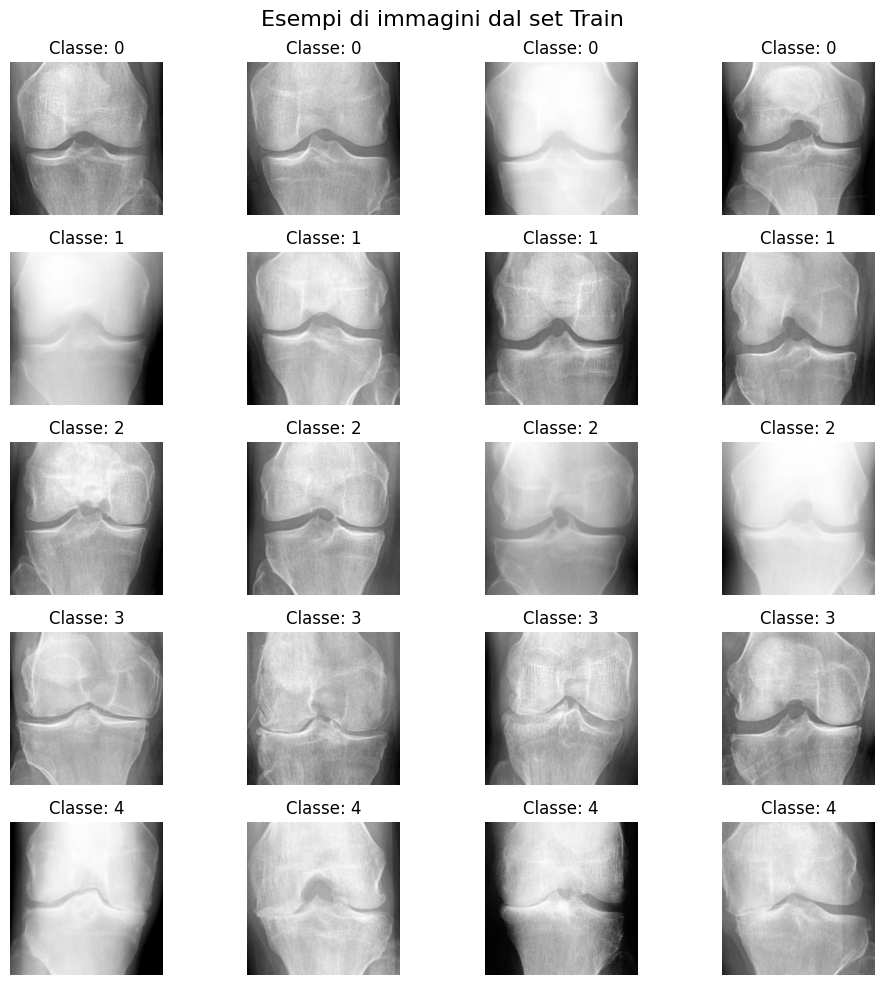

Numero di immagini per classe nel set 'train':
  Classe 0: 2286 immagini
  Classe 1: 1046 immagini
  Classe 2: 1516 immagini
  Classe 3: 757 immagini
  Classe 4: 173 immagini


Numero di immagini per classe nel set 'val':
  Classe 0: 328 immagini
  Classe 1: 153 immagini
  Classe 2: 212 immagini
  Classe 3: 106 immagini
  Classe 4: 27 immagini


Numero di immagini per classe nel set 'test':
  Classe 0: 639 immagini
  Classe 1: 296 immagini
  Classe 2: 447 immagini
  Classe 3: 223 immagini
  Classe 4: 51 immagini


Numero di immagini per classe nel set 'auto_test':
  Classe 0: 604 immagini
  Classe 1: 275 immagini
  Classe 2: 403 immagini
  Classe 3: 200 immagini
  Classe 4: 44 immagini




In [2]:
# Inizializzazione dei conteggi delle classi e delle immagini di esempio per ciascun set
class_counts = {set_name: Counter() for set_name in sets}
example_images = {set_name: [] for set_name in sets}

# Analizzare ogni set
for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    
    # Iterare attraverso le classi (0, 1, 2, 3, 4)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        class_counts[set_name][class_label] += len(images)
            
            # Prendere alcune immagini d'esempio
        if len(example_images[set_name]) < 20:  # 4 immagini per ciascuna delle 5 classi
            example_images[set_name].extend(
            [os.path.join(class_path, img) for img in images[1:5]]  # Prendi 4 immagini per classe
            )

# Ordinare le immagini di esempio per classe
example_images["train"].sort(key=lambda x: int(os.path.basename(os.path.dirname(x))))

# Visualizzare immagini di esempio dal set train 
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
fig.suptitle("Esempi di immagini dal set Train", fontsize=16)
for i, img_path in enumerate(example_images["train"]):
    row = int(os.path.basename(os.path.dirname(img_path)))
    col = i % 4
    img = Image.open(img_path)
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(f"Classe: {row}")
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

# Visualizzare il conteggio delle classi per ogni set
for set_name, counts in class_counts.items():
    print(f"Numero di immagini per classe nel set '{set_name}':")
    for class_label, count in sorted(counts.items()):
        print(f"  Classe {class_label}: {count} immagini")
    print("\n")

## *Unione dei set e conteggio delle immagini per classe*

- Per ottimizzare l'uso dei dati disponibili, unisco tutti i set principali (`train`, `val`, `test`, `auto_test`) in un unico dataset. Questo mi consente di gestire in autonomia (nei due script successivi) la divisione dei dati in set di addestramento, validazione e test, sfruttando anche le immagini presenti nella cartella `auto_test`, che altrimenti non sarebbe stata utilizzata.

- Dal conteggio delle immagini per classe emerge un evidente squilibrio (*class imbalance*). La classe 0 (ginocchio sano) è largamente predominante, mentre la classe 4 (grave osteoartrite) è rappresentata da un numero significativamente inferiore di immagini. Questo sbilanciamento sarà affrontato successivamente per garantire prestazioni robuste e bilanciate del modello.


In [3]:
# Unisco tutti i set in un unico dataset
all_images = []
all_labels = []

for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        all_images.extend([os.path.join(class_path, img) for img in images])
        all_labels.extend([int(class_label)] * len(images))
            
print(f"Numero totale di immagini: {len(all_images)}")
print(f"Numero totale di etichette: {len(all_labels)}")


Numero totale di immagini: 9786
Numero totale di etichette: 9786


Numero di immagini per classe nel dataset combinato:
  Classe 0: 3857 immagini
  Classe 1: 1770 immagini
  Classe 2: 2578 immagini
  Classe 3: 1286 immagini
  Classe 4: 295 immagini


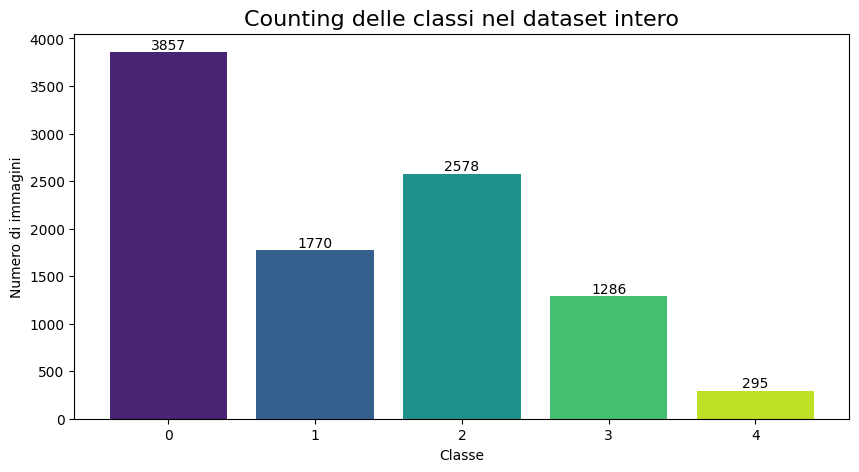

In [4]:
# Visualizzare il bilanciamento delle classi nel dataset combinato
class_counts = Counter(all_labels)
print("Numero di immagini per classe nel dataset combinato:")
for class_label, count in sorted(class_counts.items()):
    print(f"  Classe {class_label}: {count} immagini")
    
# Visualizzare il bilanciamento delle classi in un grafico a barre con colormap viridis
fig, ax = plt.subplots(figsize=(10, 5))
bar_positions = range(5)
colors = plt.cm.viridis([0.1, 0.3, 0.5, 0.7, 0.9])

counts = [class_counts[label] for label in bar_positions]
bars = ax.bar(bar_positions, counts, color=colors)

# Aggiungere il numero esatto del count sopra ogni barra
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(count), ha='center', va='bottom')
    
ax.set_title("Counting delle classi nel dataset intero", fontsize=16)
ax.set_xlabel("Classe")
ax.set_ylabel("Numero di immagini")
ax.set_xticks(bar_positions)
ax.set_xticklabels(bar_positions)   
plt.show()


## Preprocessing e Feature Extraction

In questa fase, ogni immagine presente nel dataset completo e unito subisce due tipi differenti di **preprocessing**, ciascuno finalizzato all'estrazione di diverse tipologie di **feature**.
I processi di preprocessing e estrazione delle feature sono i seguenti:

1. **Physiological Features (PREPROCESSING A):**

2. **Texture Features (PREPROCESSING B):**
   
3. **Edge Features (PREPROCESSING B):**

4. **Statistical Features (PREPROCESSING B):**

Ogni tipo di feature estratta contribuisce a una comprensione più profonda dell'immagine e della situazione fisiologica/patologica.

## Analisi immagini
Calcolo di dimensioni e datatype delle immagini

In [5]:
#Dimensione delle immagini
img_sizes = set()
for img_path in all_images:
    img = Image.open(img_path)
    img_sizes.add(img.size)
    
print(f"Dimensioni delle immagini nel dataset: {img_sizes}")

Dimensioni delle immagini nel dataset: {(224, 224)}


In [6]:
# Datatype delle immagini 
img_dtypes = set()
for img_path in all_images:
    img = Image.open(img_path)
    img_dtypes.add(img.mode)
    
print(f"Tipi di dati delle immagini nel dataset: {img_dtypes}")

#'L' significa immagini a scala di grigi [0, 255]

Tipi di dati delle immagini nel dataset: {'L'}


## Preprocessing A 
Lo scopo del preprocessing A è preparare le immagini per l'estrazione delle feature fisiologiche.


Di seguito vengono descritti i principali step dell'elaborazione:

---

1. **Ritaglio della Regione d'Interesse (ROI):**
   - Vengono rimosse **48 righe** dalla parte superiore e inferiore dell'immagine, e **10 colonne** dai bordi laterali sinistro e destro.
   - Questo passaggio è mirato a eliminare parti dell'immagine non rilevanti (come lo sfondo, la parte superiore del condilo femorale e la parte inferiore del condilo tibiale) e a concentrare l'attenzione sulla regione centrale, dove si trovano le strutture di interesse.

2. **Equalizzazione dell'istogramma:**
   - Viene applicata l'**equalizzazione dell'istogramma** per migliorare il contrasto globale dell'immagine.
   - Questo metodo cerca di uniformare contrasto e luminosità, che possono variare notevolmente da immagine a immagine. Dopo questa operazione, le immagini dovrebbero risultare visivamente più simili tra loro.

3. **Segmentazione binaria:**
   - L'immagine viene sfocata utilizzando un **filtro gaussiano**, utile per ottenere una segmentazione meno rumorosa e più stabile (senza questa operazione, l'uso del metodo di Otsu, combinato con l'equalizzazione, avrebbe prodotto risultati scadenti).
   - Si applica una sogliatura basata sul metodo di **Otsu**, trasformando l'immagine in una rappresentazione binaria.
   - Per eliminare piccoli artefatti e rafforzare i contorni, si utilizza un'operazione di **morphological closing**.

4. **Cropping delle zone mediale e laterale:**
   - Si estraggono le zone **mediale** e **laterale** della giunzione articolare, assicurandosi che in entrambi i crop la **JSW (Joint Space Width)** sia centrata nell'immagine.
   - Nei crop finali devono essere visibili:
     - La parte superiore (laterale e mediale) del condilo femorale.
     - La parte inferiore (mediale e laterale) del piatto tibiale.

---

**Nota Bene:** I valori utilizzati per definire le ROI sono stati determinati visivamente e manualmente. Questo implica che potrebbero essere ulteriormente ottimizzati per garantire risultati migliori.

(np.float64(-0.5), np.float64(203.5), np.float64(127.5), np.float64(-0.5))

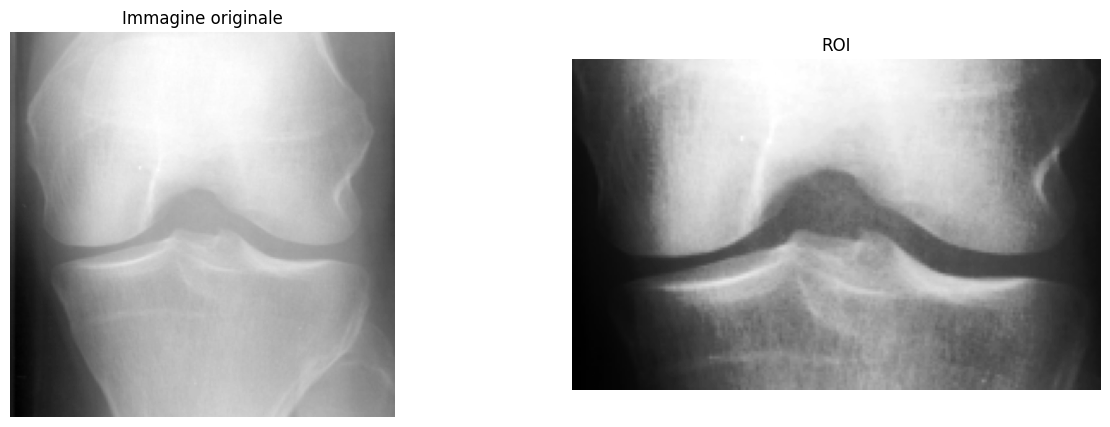

In [7]:
def preprocessing_roi(img, resize=False):
    # Rimuovere 48 righe dall'alto e dal basso e 10 colonne da sinistra e da destra
    cropped_vert = img[48:-48, 10:-10]
    
    # Equalizzare l'istogramma
    equalized = cv2.equalizeHist(cropped_vert)

    # Ridimensionare l'immagine a 128x128 se resize è True (per Preprocessing B)
    if resize:
        equalized = cv2.resize(equalized, (128, 128), interpolation=cv2.INTER_AREA)
    
    return equalized

def segmentation(img):
    blur = cv2.GaussianBlur(img,(9,9),0)
    _, thresholded = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Morphological closing per rimuovere piccoli buchi 
    kernel = np.ones((3, 3), np.uint8)
    thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=2)
    return thresholded

def crop_digits(img):
    # Croppare due immagini centrate in mezzo
    left_img = img[40:120, 42:102]
    right_img = img[40:120, 103:163]
    # Dalla 85 in poi per entrambe le immagini  metto tutti i pixel a 1 (per migliorare la segmentazione dato che la parte basse dell'immagine non è spesso segmentata)
    left_img[45:, :] = 255
    right_img[45:, :] = 255
    return left_img, right_img

# Applico le tre funzioni ad un'immagine di esempio e visualizzo i risultati
img_path = all_images[6780]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
roi = preprocessing_roi(img)
segmented = segmentation(roi)
left_img, right_img = crop_digits(segmented)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Immagine originale")
axes[0].axis("off")

axes[1].imshow(roi, cmap="gray")
axes[1].set_title("ROI")
axes[1].axis("off")




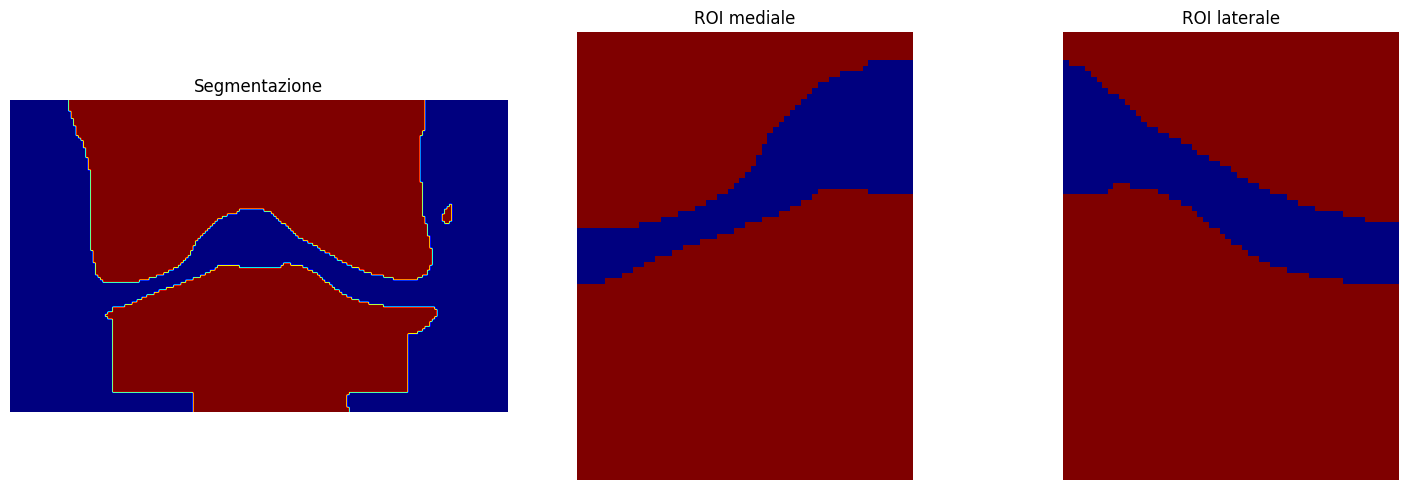

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(segmented, cmap="jet")
axes[0].set_title("Segmentazione")
axes[0].axis("off")

axes[1].imshow(left_img, cmap="jet")
axes[1].set_title("ROI mediale")
axes[1].axis("off")

axes[2].imshow(right_img, cmap="jet")
axes[2].set_title("ROI laterale")
axes[2].axis("off")

plt.tight_layout()
plt.show()



## Physiological Features Extraction

---

Per la predizione del livello di osteoartrosi del ginocchio, un parametro fondamentale è la **JSW (Joint Space Width)**. Una riduzione della JSW è associata a una maggiore severità dell'osteoartrosi. In questo script, si sono selezionate delle **feature fisiologiche** che descrivono lo spazio articolare, suddividendole in due categorie principali:


### **1. Area dello Spazio Articolare**
- **Definizione:** L'area dello spazio articolare è calcolata come la somma del numero di pixel neri (indicativi dello spazio vuoto) nelle due ROI:
  - **ROI mediale:** rappresenta il lato interno dell'articolazione.
  - **ROI laterale:** rappresenta il lato esterno dell'articolazione.
- **Metodo di calcolo:**
  - Dopo la segmentazione dell'immagine, si identificano i pixel neri (valore 0) all'interno delle ROI.
  - L'area totale dello spazio articolare è la somma dei pixel neri nelle due ROI.



### **2. Distanze Verticali tra Tibia e Femore**
- **Definizione:** Sono misurate 6 distanze verticali tra il piatto tibiale e il condilo femorale, distribuite in:
  - **3 misure mediali:** calcolate su 3 colonne equidistanti (10,30,50) della ROI mediale.
  - **3 misure laterali:** calcolate su colonne equidistanti (10,30,50) della ROI laterale.
- **Metodo di calcolo:**
  - Per ogni colonna di interesse, si individuano i pixel bianchi (bordo superiore e inferiore dello spazio articolare) nella ROI segmentata.
  - Si calcola la distanza verticale tra due pixel bianchi consecutivi, misurando il numero di pixel neri tra di essi.
  - La distanza massima viene memorizzata per ciascuna colonna come rappresentativa della larghezza dello spazio articolare in quella regione.

---

### **Implementazione delle Funzioni**
1. **Calcolo dell'area del JSW:**
   - La funzione `count_black_pixels(img)` conta il numero di pixel neri all'interno di una ROI binarizzata.
   - Applicando questa funzione separatamente alle ROI mediale e laterale e sommando il risultato, si ottiene l'area complessiva.

2. **Calcolo delle distanze massime:**
   - La funzione `max_distance_between_whites(img, columns)` calcola la distanza massima tra i pixel bianchi consecutivi nelle colonne di interesse.
   - I valori risultanti rappresentano le tre distanze dello spazio articolare nelle posizioni definite.


---

**Nota Bene:** I valori delle colonne centrali da analizzare (e.g., 10, 30, 50) sono stati scelti empiricamente in base alla struttura delle immagini e possono essere ottimizzati ulteriormente. 

In [9]:
# Funzione che calcola il numero di pixel neri in tuttta l'immagine
def count_black_pixels(img):
    return np.sum(img == 0)

In [10]:
# Definizione della funzione max_distance_between_whites
def max_distance_between_whites(img, columns):
    # Dizionario per memorizzare la distanza massima per ogni colonna
    max_distances = {}

    for col in columns:
        # Estrai i valori della colonna
        col_values = img[:, col]
        # Trova gli indici dei pixel bianchi
        white_indices = np.where(col_values == 255)[0]

        # Inizializza la distanza massima a 0
        max_distance = 0

        # Calcola la distanza tra pixel bianchi consecutivi
        for i in range(len(white_indices) - 1):
            start = white_indices[i]
            end = white_indices[i + 1]
            
            # Conta i pixel neri tra due pixel bianchi consecutivi
            black_pixel_count = np.sum(col_values[start + 1:end] == 0)
            
            # Aggiorna la distanza massima
            max_distance = max(max_distance, black_pixel_count)

        # Salva la distanza massima per la colonna
        max_distances[col] = max_distance

    return max_distances

# Colonne di interesse
columns = [10, 30, 50]

In [11]:
# Inizializzo le liste per raccogliere i risultati
black_pixel_counts = []  # Lista per l'area della JSW
left_max_distances = []  # Lista per le distanze massime tra i pixel bianchi nella ROI mediale
right_max_distances = []  # Lista per le distanze massime tra i pixel bianchi nella ROI laterale

# Ciclo su tutte le immagini nel dataset
for img_path in all_images:
    # Leggo l'immagine in scala di grigi
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Eseguo il preprocessing dell'immagine (ritaglio e equalizzazione dell'istogramma)
    preprocessed_img = preprocessing_roi(img)
    
    # Eseguo la segmentazione per ottenere un'immagine binaria
    thresholded_img = segmentation(preprocessed_img)
    
    # Croppo le ROI mediale e laterale dalla segmentazione
    left_img, right_img = crop_digits(thresholded_img)
    
    # Calcolo il numero di pixel neri nelle due ROI e li sommo
    black_pixel_counts.append(count_black_pixels(left_img) + count_black_pixels(right_img))
    
    # Calcolo la distanza massima tra i pixel bianchi nella ROI mediale
    left_max_distances.append(max_distance_between_whites(left_img, columns))
    
    # Calcolo la distanza massima tra i pixel bianchi nella ROI laterale
    right_max_distances.append(max_distance_between_whites(right_img, columns))

In [12]:
# Creazione di un dizionario con le feature fisiologiche estratte e le etichette
data = {
    "black_pixel_count": black_pixel_counts,  # Conteggio totale dei pixel neri per immagine
    "left_max_distance_10": [d[10] for d in left_max_distances],  # Distanza massima per la colonna 10 nella ROI sinistra
    "left_max_distance_30": [d[30] for d in left_max_distances],  # Distanza massima per la colonna 30 nella ROI sinistra
    "left_max_distance_50": [d[50] for d in left_max_distances],  # Distanza massima per la colonna 50 nella ROI sinistra
    "right_max_distance_10": [d[10] for d in right_max_distances],  # Distanza massima per la colonna 10 nella ROI destra
    "right_max_distance_30": [d[30] for d in right_max_distances],  # Distanza massima per la colonna 30 nella ROI destra
    "right_max_distance_50": [d[50] for d in right_max_distances],  # Distanza massima per la colonna 50 nella ROI destra
    "label": all_labels  # Le etichette associate alle immagini
}

# Creazione di un DataFrame pandas con i dati raccolti
physiological_df = pd.DataFrame(data)

# Visualizzazione delle prime 5 righe del DataFrame
physiological_df.head()

,black_pixel_count,left_max_distance_10,left_max_distance_30,left_max_distance_50,right_max_distance_10,right_max_distance_30,right_max_distance_50,label
0,1917,4,10,24,32,20,8,0
1,2055,7,14,30,28,15,11,0
2,2193,6,18,23,34,18,14,0
3,1500,1,10,30,20,10,4,0
4,1939,12,14,0,0,12,9,0


In [13]:
# Salvataggio del DataFrame in un file CSV 
physiological_df.to_csv("physiological_features.csv", index=False)

### Analisi delle Feature Fisiologiche Estratte

Come si può notare, all'aumentare della severità dell'osteoartrosi, l'area della **JSW** (Joint Space Width) calcolata diminuisce, confermando la correttezza del calcolo effettuato. Questo comporta che, nelle immagini con un grado più avanzato di artrosi, lo spazio tra il femore e il piatto tibiale risulta ridotto, come era previsto.

Per quanto riguarda le **distanze mediali** e **laterali**, possiamo osservare che i barplot mostrano una **simmetria** tra i due lati del ginocchio (sinistro e destro). In particolare, la distanza mediale 1 è simile alla distanza laterale 3, la distanza mediale 2 è simile alla laterale 2, e la distanza mediale 3 è simile alla laterale 1. Ciò suggerisce che le distanze per classe variano in modo simile per entrambi i lati del ginocchio, indicando un comportamento coerente nelle misurazioni.

Inoltre, le distanze più centrali (mediali 3 e laterali 1) mostrano chiaramente come, al diminuire della distanza tra il femore e il piatto tibiale, aumenta il grado di osteoartrosi. Per tutte le altre distanze, si nota che i casi con un grado più avanzato di artrosi (gradi 3 e 4) presentano le distanze minori, come previsto.

Questi risultati confermano l'ipotesi secondo cui la riduzione dello spazio articolare (JSW) e la diminuzione delle distanze tra femore e piatto tibiale sono indicatori rilevanti per il grado di osteoartrosi.

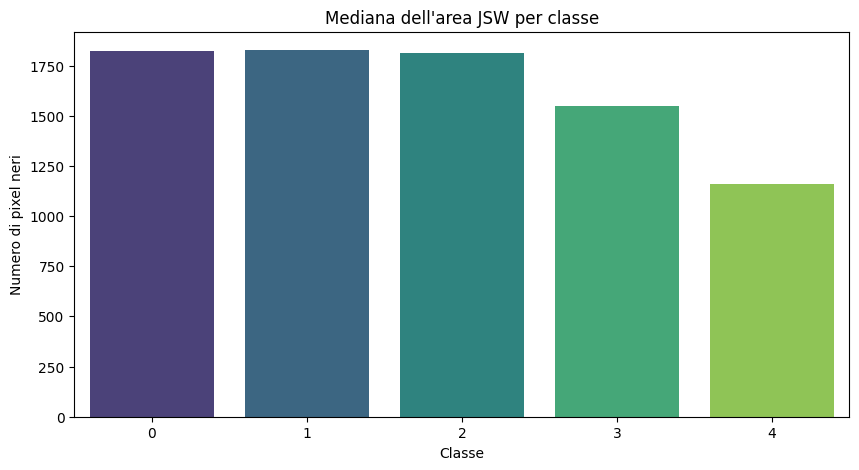

In [14]:
# Barplot per visualizzare la mediana dell'area JSW per ciascuna classe
median_df = physiological_df.groupby('label')['black_pixel_count'].median().reset_index()


plt.figure(figsize=(10, 5))
sns.barplot(x="label", y="black_pixel_count", data=median_df, palette="viridis")
plt.title("Mediana dell'area JSW per classe")
plt.xlabel("Classe")
plt.ylabel("Numero di pixel neri")
plt.show()



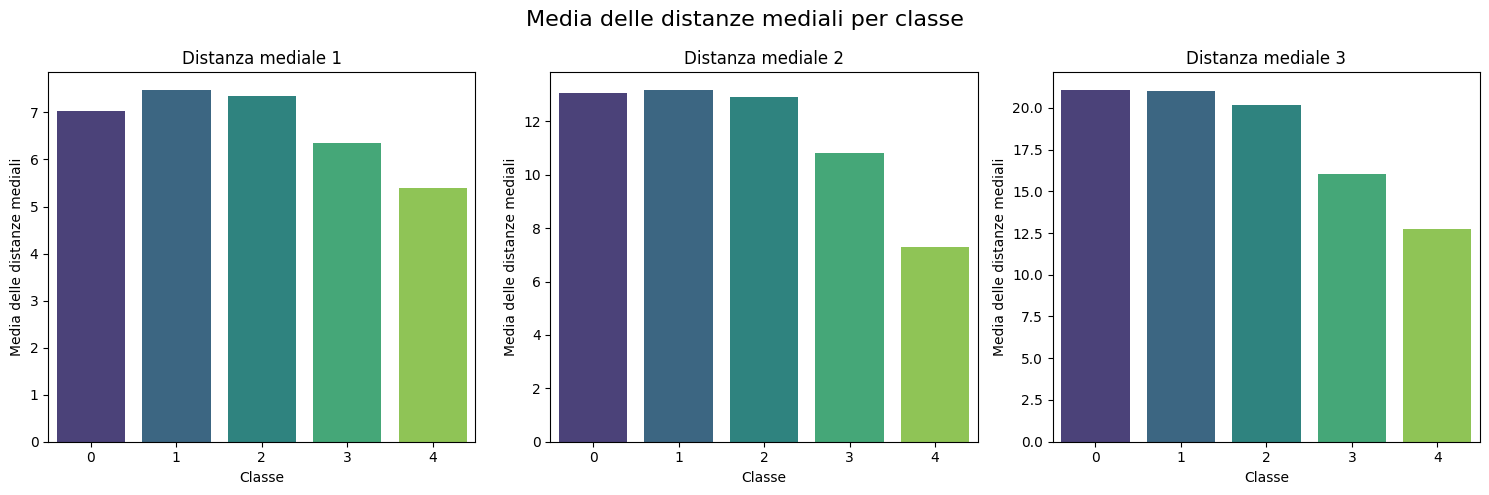

In [15]:
# Visualizzazione della media delle distanze mediali per ciascuna classe

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Media delle distanze mediali per classe", fontsize=16)

for i, col in enumerate([10, 30, 50]):
    mean_df = physiological_df.groupby('label')[f"left_max_distance_{col}"].mean().reset_index()
    sns.barplot(x="label", y=f"left_max_distance_{col}", data=mean_df, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Distanza mediale {i+1}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel("Media delle distanze mediali")
    
plt.tight_layout()
plt.show()

    

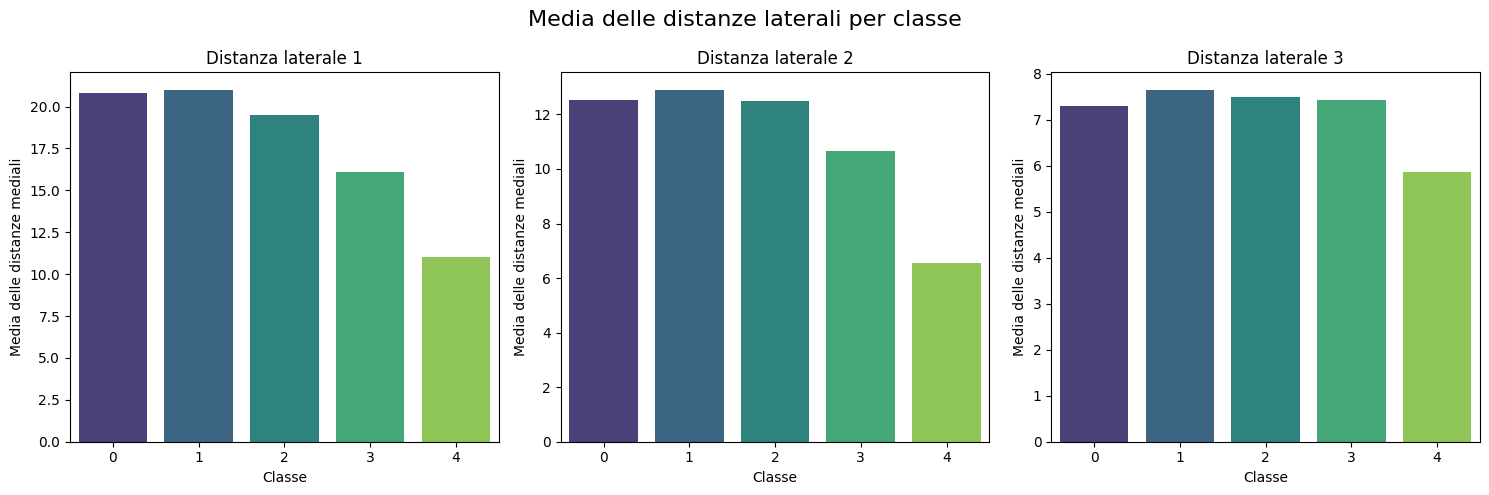

In [16]:
# Visualizzazione della media delle distanze laterali per ciascuna classe

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Media delle distanze laterali per classe", fontsize=16)

for i, col in enumerate([10, 30, 50]):
    mean_df = physiological_df.groupby('label')[f"right_max_distance_{col}"].mean().reset_index()
    sns.barplot(x="label", y=f"right_max_distance_{col}", data=mean_df, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Distanza laterale {i+1}")
    axes[i].set_xlabel("Classe")
    axes[i].set_ylabel("Media delle distanze mediali")
    
plt.tight_layout()
plt.show()

## Preprocessing B
---

Questo passaggio è dedicato al calcolo delle **feature** direttamente associate all'immagine stessa, come le **edge features**, le **texture features** e le **statistical features**. Per questo motivo, il preprocessing B include i seguenti passaggi:

1. **Ritaglio della Regione d'Interesse (ROI):**
   - Vengono rimosse **48 righe** dalla parte superiore e inferiore dell'immagine, e **10 colonne** dai bordi laterali sinistro e destro.
   - L'obiettivo di questo passaggio è eliminare porzioni dell'immagine che non sono rilevanti (come lo sfondo, la parte superiore del condilo femorale e la parte inferiore del condilo tibiale) e focalizzarsi sulla **regione centrale**, dove sono localizzate le strutture di interesse per l'analisi.

2. **Equalizzazione dell'Istogramma:**
   - Viene applicata l'**equalizzazione dell'istogramma** per migliorare il contrasto complessivo dell'immagine.
   - Questo processo uniforma il contrasto e la luminosità, che potrebbero variare significativamente tra le diverse immagini. Dopo l'applicazione dell'equalizzazione, le immagini risulteranno visivamente più omogenee, facilitando il processo di analisi successivo.

3. **Ridimensionamento (resize) a 128x128:**
   - L'immagine viene ridimensionata a **128x128 pixel** (con potenze di 2) per ridurre il numero complessivo di pixel e quindi il peso computazionale. Questo passaggio consente anche di mantenere la stessa lunghezza e larghezza per facilitare la suddivisione in **patch** da 32x32 pixel (16 patch totali per immagine).

4.	**Divisione in Patch**:
	- L’immagine viene successivamente divisa in patch di dimensione **32x32 pixel**.
	- Questo passaggio è utile per estrarre le feature locali in modo indipendente da ogni regione dell’immagine.
	- Ogni immagine viene suddivisa in 16 patch, che possono essere poi analizzate separatamente per ottenere informazioni dettagliate sulle caratteristiche di texture, bordi e statistiche locali.

Dimensioni dell'immagine ROI: (128, 128)


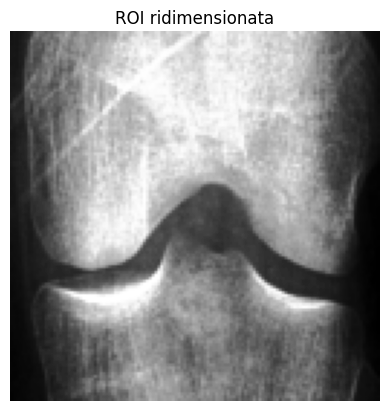

In [17]:
# Carico immagine esempio e verifico la dimensione della ROI
img_path = all_images[0]  
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
roi = preprocessing_roi(img, resize=True)  # Applico il preprocessing alla ROI, con ridimensionamento (questa volta il parametro resize è True)
print(f"Dimensioni dell'immagine ROI: {roi.shape}")  

# Visualizzo la ROI
plt.title("ROI ridimensionata")
plt.imshow(roi, cmap="gray")  
plt.axis("off")  
plt.show()  

Numero di patch ottenute: 16
Dimensioni di ogni patch: (32, 32)


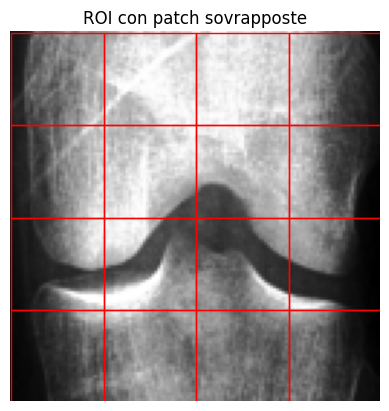

In [18]:
# Funzione per dividere un'immagine in patch di 32x32
def divide_into_patches(image, patch_size=32):
  
    patches = []

    # Itera sulle coordinate
    for i in range(0, 128, patch_size):
        for j in range(0, 128, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            
            # Verifica che la patch abbia le dimensioni corrette
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
    
    return np.array(patches)


# Divido in patch
patches = divide_into_patches(roi, patch_size=32)

# Stampa risultato
print(f"Numero di patch ottenute: {patches.shape[0]}")
print(f"Dimensioni di ogni patch: {patches.shape[1:]}")

# Itera sulle coordinate per disegnare i rettangoli
fig, ax = plt.subplots()
ax.imshow(roi, cmap="gray")

for i in range(0, 128, 32):
    for j in range(0, 128, 32):
        # Crea un rettangolo
        rect = Rectangle((j, i), 32, 32, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
plt.title("ROI con patch sovrapposte")
plt.axis("off")
plt.show()

**N.B.**
Le patch che contengono la **JSW** (Joint Space Width) sono solo le seguenti: **5, 6, 8, 9, 10, 11** (contare partendo da 0 da in alto a sinistra). Questo è un dettaglio importante da tenere a mente per la **feature reduction** nello script successivo.

## Texture Features Extraction

---

L'estrazione delle **texture features** serve ad analizzare la struttura delle immagini a livello locale. In questo contesto, sono state utilizzate due tecniche principali:

1. **GLCM (Gray Level Co-occurrence Matrix):**
   - La **GLCM** è una matrice che descrive la distribuzione di intensità dei pixel di una immagine rispetto a uno o più angoli e distanze specificati. Da questa matrice, possiamo estrarre diverse proprietà, come:
     - **Contrast:** Indica la differenza tra i livelli di intensità dei pixel adiacenti.
     - **Dissimilarity:** Misura la disuguaglianza tra i pixel adiacenti.
     - **Homogeneity:** Indica quanto i pixel siano simili tra loro in un'area.
     - **Energy:** Misura l'intensità totale della matrice.
     - **Correlation:** Misura la linearità tra pixel adiacenti.

2. **LBP (Local Binary Pattern):**
   - Il **LBP** è un operatore che trasforma un'immagine in un insieme di pattern binari che descrivono la **struttura locale** di un'area. I valori LBP sono particolarmente utili per catturare variazioni sottili nella texture, come bordi o discontinuità. L'istogramma risultante descrive la distribuzione di questi pattern su tutta la patch dell'immagine.

- Le **GLCM features** sono utili per analizzare la struttura globale e le proprietà di contrasto dell'immagine, che possono essere indicative della gravità della patologia.
- Le **LBP features**, invece, forniscono informazioni dettagliate sulla texture locale, catturando pattern che potrebbero non essere evidenti nelle caratteristiche globali.
- Combinando entrambe le tecniche, otteniamo un'analisi più completa della texture dell'immagine, che può essere usata per migliorare la classificazione e la predizione dello stato patologico.


In [19]:
# Funzione per calcolare le caratteristiche di texture
def compute_texture_features(patches):
    """
    Calcola le feature di texture per ciascuna patch.
    Le feature includono proprietà GLCM e LBP, concatenate in un unico array.

    :param patches: array NumPy contenente tutte le patch (num_patches, patch_size, patch_size).
    :return: array NumPy con tutte le feature concatenate.
    """
    feature_list = []
    feature_titles = []
    
    # Titoli delle feature GLCM
    glcm_titles = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    
    for i, patch in enumerate(patches):
        patch_features = []
        
        # Calcolo GLCM (matrice di co-occorrenza)
        glcm = graycomatrix(patch, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
        
        # Estrazione di feature da GLCM e memorizzazione nel dizionario
        for title in glcm_titles:
            patch_features.append(graycoprops(glcm, title).mean())
            feature_titles.append(f'{title}_patch_{i}')
        
        # Calcolo Local Binary Pattern (LBP)
        lbp = local_binary_pattern(patch, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 10), density=True)
        
        # Memorizzazione dell'istogramma LBP nel dizionario
        for j, value in enumerate(lbp_hist):
            patch_features.append(value)
            feature_titles.append(f'lbp_hist_{j}_patch_{i}')
        
        # Aggiungi le feature della patch alla lista
        feature_list.extend(patch_features)
    
    return np.array(feature_list), feature_titles

L'applicazione della funzione di estrazione delle **features** richiede un tempo significativo, soprattutto considerando che vengono calcolate numerose caratteristiche su 16 patch per ciascuna delle circa 1000 immagini. Questo processo risulta particolarmente pesante in termini computazionali. 

Per evitare di dover ricalcolare le feature ogni volta, è stato implementato il salvataggio dei risultati in un **file CSV**. In questo modo, i dati estratti sono salvati una sola volta e possono essere successivamente letti direttamente, senza la necessità di eseguire nuovamente il calcolo delle feature.


In [20]:

'''# Calcolo delle feature di texture per le patch di tutte le immagini
texture_features = []
texture_feature_titles = []

for img_path in all_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    roi = preprocessing_roi(img, resize=True)
    patches = divide_into_patches(roi, patch_size=32)
    features, titles = compute_texture_features(patches)
    texture_features.append(features)
    texture_feature_titles = titles
    
# Creazione di un DataFrame per memorizzare le feature di texture
texture_df = pd.DataFrame(data=texture_features, columns=texture_feature_titles)
texture_df['label'] = all_labels

texture_df.head()'''

"# Calcolo delle feature di texture per le patch di tutte le immagini\ntexture_features = []\ntexture_feature_titles = []\n\nfor img_path in all_images:\n    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)\n    roi = preprocessing_roi(img, resize=True)\n    patches = divide_into_patches(roi, patch_size=32)\n    features, titles = compute_texture_features(patches)\n    texture_features.append(features)\n    texture_feature_titles = titles\n    \n# Creazione di un DataFrame per memorizzare le feature di texture\ntexture_df = pd.DataFrame(data=texture_features, columns=texture_feature_titles)\ntexture_df['label'] = all_labels\n\ntexture_df.head()"

In [21]:
# Salvataggio del DataFrame in un file CSV
#texture_df.to_csv("texture_features.csv", index=False)


## Statistical fetures Extraction

L'**estrazione delle features statistiche** fornisce informazioni cruciali riguardo la distribuzione dei pixel all'interno delle patch. Queste caratteristiche possono essere utilizzate per descrivere e differenziare le varie regioni di interesse nell'immagine.

La funzione di estrazione calcola una serie di statistiche per ciascuna patch, le quali includono:

1. **Media (mean)**: 
   - È utile per comprendere l'intensità complessiva dei pixel, un'informazione cruciale in molte applicazioni, come il riconoscimento di pattern in immagini mediche.

2. **Varianza (variance)**: 
   - La **varianza** è utile per identificare zone più eterogenee o più omogenee, come ad esempio aree più danneggiate nelle radiografie.

3. **Skewness (asimmetria)**:
   - Lo **skewness** misura la asimmetria della distribuzione dei valori dei pixel.

4. **Kurtosis (curtosi)**:
   - una **kurtosi** elevata indica una distribuzione concentrata attorno alla media, mentre una bassa indica una distribuzione più piatta.

In [22]:
# Funzione per calcolare le caratteristiche statistiche
def compute_statistical_features(patches):
    """
    Calcola le caratteristiche statistiche (media, varianza, skewness, kurtosis) per ciascuna patch.

    :param patches: array NumPy contenente tutte le patch (num_patches, patch_size, patch_size).
    :return: array NumPy con tutte le feature concatenate e una lista di titoli delle feature.
    """
    feature_list = []
    feature_titles = []
    
    for i, patch in enumerate(patches):
        patch_features = []
        
        # Calcolo media e varianza
        patch_features.append(np.mean(patch))
        feature_titles.append(f'mean_patch_{i}')
        
        patch_features.append(np.var(patch))
        feature_titles.append(f'variance_patch_{i}')
        
        # Calcolo skewness e kurtosis
        patch_features.append(skew(patch.flatten()))
        feature_titles.append(f'skewness_patch_{i}')
        
        patch_features.append(kurtosis(patch.flatten()))
        feature_titles.append(f'kurtosis_patch_{i}')
        
        # Aggiungi le feature della patch alla lista
        feature_list.extend(patch_features)
    
    return np.array(feature_list), feature_titles


In [23]:
'''# Calcolo delle feature statistiche per le patch di tutte le immagini
statistical_features = []
statistical_feature_titles = []

for img_path in all_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    roi = preprocessing_roi(img, resize=True)
    patches = divide_into_patches(roi, patch_size=32)
    features, titles = compute_statistical_features(patches)
    statistical_features.append(features)
    statistical_feature_titles = titles
    
# Creazione di un DataFrame per memorizzare le feature statistiche
statistical_df = pd.DataFrame(data=statistical_features, columns=statistical_feature_titles)
statistical_df['label'] = all_labels'''

"# Calcolo delle feature statistiche per le patch di tutte le immagini\nstatistical_features = []\nstatistical_feature_titles = []\n\nfor img_path in all_images:\n    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)\n    roi = preprocessing_roi(img, resize=True)\n    patches = divide_into_patches(roi, patch_size=32)\n    features, titles = compute_statistical_features(patches)\n    statistical_features.append(features)\n    statistical_feature_titles = titles\n    \n# Creazione di un DataFrame per memorizzare le feature statistiche\nstatistical_df = pd.DataFrame(data=statistical_features, columns=statistical_feature_titles)\nstatistical_df['label'] = all_labels"

In [24]:
# Salvare il DataFrame in un file CSV
#statistical_df.to_csv("statistical_features.csv", index=False)


In [25]:
# Funzione per calcolare le caratteristiche di bordo
def compute_edge_features(patches):
    """
    Calcola le caratteristiche di bordo (densità dei bordi, gradiente medio) per ciascuna patch.

    :param patches: array NumPy contenente tutte le patch (num_patches, patch_size, patch_size).
    :return: lista di dizionari, uno per ciascuna patch.
    """
    feature_list = []
    feature_titles = []
    
    for i,patch in enumerate(patches):
        patch_features = []
        
        # Calcola il gradiente orizzontale e verticale usando il filtro di Sobel
        sobel_x = filters.sobel_v(patch)
        sobel_y = filters.sobel_h(patch)
        
        # Gradiente medio
        gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        patch_features.append(np.mean(gradient_magnitude))
        feature_titles.append(f'mean_gradient_{i}')
        
        # Densità dei bordi (somma dei gradienti / numero di pixel)
        edge_density = np.sum(gradient_magnitude > 0) / gradient_magnitude.size
        patch_features.append(edge_density)
        feature_titles.append(f'edge_density{i}')
        
        # Aggiungi le feature della patch alla lista
        feature_list.extend(patch_features)
    
    return np.array(feature_list), feature_titles



In [26]:
'''# Calcolo delle feature statistiche per le patch di tutte le immagini
edge_features = []
edge_feature_titles = []

for img_path in all_images:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    roi = preprocessing_roi(img, resize=True)
    patches = divide_into_patches(roi, patch_size=32)
    features, titles = compute_edge_features(patches)
    edge_features.append(features)
    edge_feature_titles = titles
    
# Creazione di un DataFrame per memorizzare le feature bordo
edge_df = pd.DataFrame(data=edge_features, columns=edge_feature_titles)
edge_df['label'] = all_labels'''

"# Calcolo delle feature statistiche per le patch di tutte le immagini\nedge_features = []\nedge_feature_titles = []\n\nfor img_path in all_images:\n    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)\n    roi = preprocessing_roi(img, resize=True)\n    patches = divide_into_patches(roi, patch_size=32)\n    features, titles = compute_edge_features(patches)\n    edge_features.append(features)\n    edge_feature_titles = titles\n    \n# Creazione di un DataFrame per memorizzare le feature bordo\nedge_df = pd.DataFrame(data=edge_features, columns=edge_feature_titles)\nedge_df['label'] = all_labels"

In [27]:
#edge_df

In [28]:
# Salvare il DataFrame in un file CSV
#edge_df.to_csv("edge_features.csv", index=False)

## Concatenzaione dataset
Dopo aver estratto tutte le **feature** da ciascuna immagine (statistiche, texture, edge e fisiologiche), i vari DataFrame vengono uniti per creare un unico dataset generale. Questo dataset rappresenta l'insieme completo di tutte le informazioni estratte dalle immagini e sarà utilizzato per le successive fasi di analisi e per l'addestramento dei modelli.


In [29]:
statistical_df = pd.read_csv("statistical_features.csv")
texture_df = pd.read_csv("texture_features.csv")
edge_df = pd.read_csv("edge_features.csv")
physiological_df = pd.read_csv("physiological_features.csv")


In [30]:
# Merge dei DataFrame mantenendo solo una colonna label e non tutte e tre
df = pd.concat([statistical_df, texture_df, edge_df,physiological_df], axis=1)
df = df.loc[:,~df.columns.duplicated()]


In [31]:
df

,mean_patch_0,variance_patch_0,skewness_patch_0,kurtosis_patch_0,mean_patch_1,variance_patch_1,skewness_patch_1,kurtosis_patch_1,mean_patch_2,variance_patch_2,...,edge_density14,mean_gradient_15,edge_density15,black_pixel_count,left_max_distance_10,left_max_distance_30,left_max_distance_50,right_max_distance_10,right_max_distance_30,right_max_distance_50
0,111.491211,2418.224532,-0.208841,-0.702811,222.791016,562.768826,-0.643435,-0.536283,226.696289,255.356002,...,1.0,0.056150,1.000000,1917,4,10,24,32,20,8
1,165.416992,2838.573188,0.083212,-1.259813,238.720703,167.084103,-0.810764,-0.238976,203.866211,627.119796,...,1.0,0.063339,1.000000,2055,7,14,30,28,15,11
2,163.733398,3375.652556,0.074729,-1.488112,222.668945,577.670676,-1.067946,0.833048,207.808594,445.930161,...,1.0,0.053238,1.000000,2193,6,18,23,34,18,14
3,89.506836,2934.304641,0.588146,-0.896873,237.740234,309.504787,-1.581933,1.896421,238.451172,254.505428,...,1.0,0.040012,1.000000,1500,1,10,30,20,10,4
4,93.767578,2993.475277,0.626822,-0.609997,231.958008,318.348823,-0.742086,-0.258058,233.714844,233.047592,...,1.0,0.041624,0.999023,1939,12,14,0,0,12,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9781,89.445312,3617.094666,0.325479,-0.892170,239.191406,168.025864,-1.708718,4.277516,232.140625,189.613037,...,1.0,0.039107,1.000000,1981,13,17,20,19,16,10
9782,77.159180,3096.292045,0.801268,-0.473148,216.989258,608.594611,-0.556973,-0.387746,221.231445,404.476707,...,1.0,0.075711,1.000000,2083,7,12,17,29,19,20
9783,111.754883,3304.069800,0.035717,-1.288420,228.938477,153.282348,0.001886,-0.781567,245.514648,55.749785,...,1.0,0.031550,0.956055,1751,13,19,19,26,0,5
9784,45.732422,455.779964,-0.100158,-1.107253,154.916992,1949.330024,-0.098232,-1.369447,243.115234,109.678127,...,1.0,0.041508,1.000000,1090,0,1,0,0,0,0


## Creazione del Dataset e Suddivisione in Set di Allenamento e Validazione

Dopo aver estratto tutte le **feature** dalle immagini e aver creato il dataset finale, sono stati scritti due script per, successivamete alla rimozione di una porzione per il test set che viene usato solo per testare il modello alla fine, suddividere i dati in set di allenamento e di validazione, utilizzando due metodi di **splitting** differenti:

1. **Hold-Out Method:**
   - Questo metodo suddivide il dataset in due set: uno per l'allenamento e uno per la validazione. Una percentuale delle immagini viene separata per la validazione, mentre il resto viene utilizzato per allenare il modello. 
   - *BENEDETTO_HW3_ES_1B.ipynb*

2. **Stratified Cross-Validation (Validazione Incrociata):**
   - La **cross-validation** è una tecnica che divide il dataset in **K** sottoinsiemi (folds) e utilizza ciascun sottoinsieme come set di validazione mentre gli altri vengono utilizzati per l'allenamento. Questo processo viene ripetuto per ogni fold, garantendo che ogni immagine sia usata sia per l'allenamento che per la validazione.
   - *BENEDETTO_HW3_ES_1C.ipynb*

